In [31]:
import os
import shutil
import pandas as pd

# Output directories for organized images
output_train_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed/train'
output_val_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed/val'
output_test_dir = '/media/mydisk/ICDCIT/Split_APTOS_preprocessed/test'


In [32]:
from tensorflow.keras import backend as K
K.clear_session()

In [33]:
import tensorflow as tf

# List physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Optionally, list details
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [34]:
from tensorflow.keras import mixed_precision

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

In [35]:
import tensorflow as tf
import os

# Constants
TARGET_SIZE = (224, 224)
BATCH_SIZE = 64
NUM_CLASSES = len(os.listdir(output_train_dir)) 

# Data Parsing and Augmentation
def parse_tfrecord(example):
    # Define TFRecord schema
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Parse example
    parsed = tf.io.parse_single_example(example, feature_description)
    # Decode and preprocess image
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
    label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
    return image, label

# Dataset Loader
def load_tfrecord_dataset(filenames, batch_size, shuffle=True):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(lambda x: parse_tfrecord(x), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)



In [36]:
train_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/train.tfrecord'], BATCH_SIZE)
val_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/val.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation
test_dataset = load_tfrecord_dataset(['/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/test.tfrecord'], BATCH_SIZE, shuffle=False)  # No augmentation


In [37]:
# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
train_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_balanced/train.tfrecord')
val_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_balanced/val.tfrecord')

print(f'val_samples: {val_samples}')
print(f'train_samples: {train_samples}')

val_samples: 366
train_samples: 2930


In [38]:
from collections import Counter

def calculate_class_weights(data_dir):
    class_counts = Counter()
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        num_samples = len([f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[label] += num_samples
    
    # Total number of samples
    total_samples = sum(class_counts.values())
    num_classes = len(class_counts)
    
    # Calculate class weights
    class_weights = {i: total_samples / (num_classes * count) for i, count in class_counts.items()}
    
    return class_weights, class_counts

# Calculate class weights from the training directory
class_weights, class_counts = calculate_class_weights(output_train_dir)
print(f'Class weights: {class_weights}')


Class weights: {0: 0.4086471408647141, 1: 1.9533333333333334, 2: 0.7252475247524752, 3: 3.8051948051948052, 4: 2.5042735042735043}


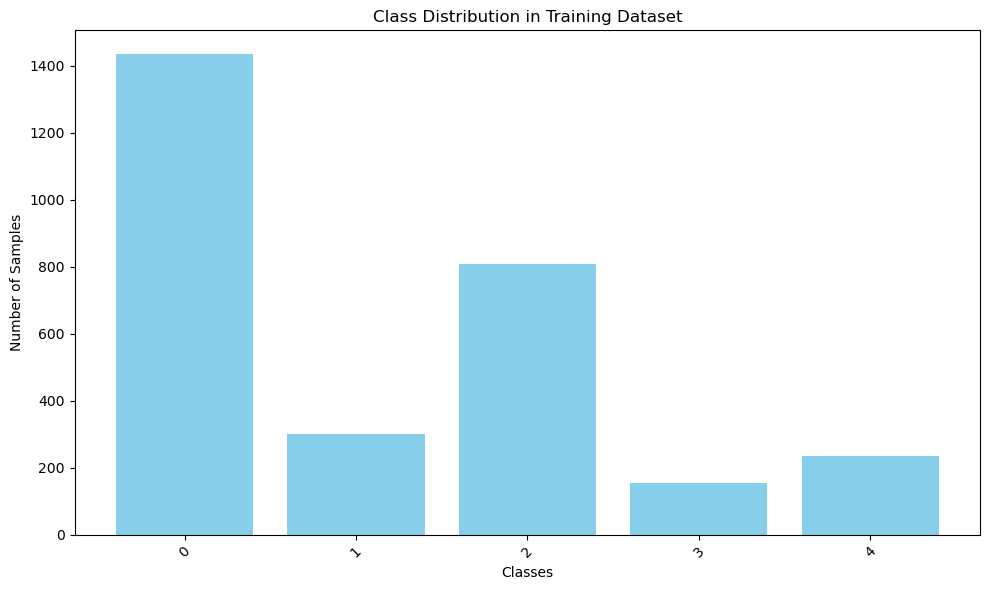

In [39]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Extract class names and counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Training Dataset')
    plt.xticks(rotation=45)  # Rotate class labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    plt.show()

# Call the function with your class counts dictionary
plot_class_distribution(class_counts)


In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Optional

class SimpleMetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, every_n_epochs: int = 5, save_plots: bool = False, plot_path: str = 'accuracy_loss_plot_preprocessed.png'):
        super().__init__()
        self.every_n_epochs = every_n_epochs
        self.save_plots = save_plots
        self.plot_path = plot_path
        self.history = {
            'epochs': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_loss': [],
            'val_loss': []
        }

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        """Store accuracy and loss at the end of each epoch."""
        if logs is None:
            logs = {}
            
        # Append accuracy and loss to history
        self.history['epochs'].append(epoch + 1)
        self.history['train_accuracy'].append(logs.get('accuracy', 0))
        self.history['val_accuracy'].append(logs.get('val_accuracy', 0))
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        
        # Log the results for this epoch
        tf.print(f'Epoch {epoch + 1}: Train Accuracy: {logs.get("accuracy", 0):.4f}, Val Accuracy: {logs.get("val_accuracy", 0):.4f}, '
                 f'Train Loss: {logs.get("loss", 0):.4f}, Val Loss: {logs.get("val_loss", 0):.4f}')
        
        # Plot the metrics every n epochs or at the last epoch
        if (epoch + 1) % self.every_n_epochs == 0 or epoch == self.params['epochs'] - 1:
            self.plot_metrics()

    def plot_metrics(self) -> None:
        """Plot accuracy and loss over epochs."""
        try:
            # Create a new figure for each plot to avoid overlapping
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Plot accuracy
            axes[0].plot(self.history['epochs'], self.history['train_accuracy'], label='Train Accuracy', marker='o')
            axes[0].plot(self.history['epochs'], self.history['val_accuracy'], label='Val Accuracy', marker='o')
            axes[0].set_title('Accuracy over Epochs')
            axes[0].set_xlabel('Epochs')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Plot loss
            axes[1].plot(self.history['epochs'], self.history['train_loss'], label='Train Loss', marker='o')
            axes[1].plot(self.history['epochs'], self.history['val_loss'], label='Val Loss', marker='o')
            axes[1].set_title('Loss over Epochs')
            axes[1].set_xlabel('Epochs')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            
            # Save or show the plot
            if self.save_plots:
                plt.savefig(self.plot_path)
                plt.close()  # Close the figure to avoid display in interactive environments
            else:
                plt.show()  # Show the plot in interactive mode
                
        except Exception as e:
            tf.print(f"Error plotting metrics: {str(e)}")


In [41]:
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, 
                                     Dropout, BatchNormalization, Conv2D, 
                                     multiply, Lambda)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal


base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)



In [42]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

model.compile(
optimizer=Adam(learning_rate=0.0001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=True)

history = model.fit(
train_dataset,
steps_per_epoch=train_samples // BATCH_SIZE,
validation_data=val_dataset,
validation_steps=val_samples // BATCH_SIZE,
epochs=25,               
callbacks=[custom_metrics_callback, model_checkpoint],
class_weight=class_weights
)


Epoch 1/25


2024-12-04 19:04:48.193014: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6864 - auc: 0.8853 - loss: 0.9986 - precision: 0.7625 - recall: 0.5431Epoch 1: Train Accuracy: 0.5656, Val Accuracy: 0.8781, Train Loss: 1.6074, Val Loss: 0.2524

Epoch 1: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 50s 177ms/step - accuracy: 0.6837 - auc: 0.8844 - loss: 1.0118 - precision: 0.7613 - recall: 0.5408 - val_accuracy: 0.8781 - val_auc: 0.9923 - val_loss: 0.2524 - val_precision: 0.8942 - val_recall: 0.8719
Epoch 2/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 12:59 18s/step - accuracy: 0.3600 - auc: 0.7131 - loss: 1.6674 - precision: 1.0000 - recall: 0.1400

/home/ritika/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Epoch 2: Train Accuracy: 0.3600, Val Accuracy: 0.8781, Train Loss: 1.6674, Val Loss: 0.2567

Epoch 2: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.3600 - auc: 0.7131 - loss: 1.6674 - precision: 1.0000 - recall: 0.1400 - val_accuracy: 0.8781 - val_auc: 0.9920 - val_loss: 0.2567 - val_precision: 0.8885 - val_recall: 0.8719
Epoch 3/25
 2/45 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.0000e+00 - auc: 0.1180 - loss: 1.1295 - precision: 0.0000e+00 - recall: 0.0000e+00

2024-12-04 19:05:37.236553: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3036 - auc: 0.5608 - loss: 1.1077 - precision: 0.6607 - recall: 0.1964Epoch 3: Train Accuracy: 0.4601, Val Accuracy: 0.9312, Train Loss: 1.3179, Val Loss: 0.1353

Epoch 3: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 0.3070 - auc: 0.5650 - loss: 1.1123 - precision: 0.6644 - recall: 0.1981 - val_accuracy: 0.9312 - val_auc: 0.9978 - val_loss: 0.1353 - val_precision: 0.9367 - val_recall: 0.9250
Epoch 4/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5400 - auc: 0.8571 - loss: 1.3817 - precision: 0.9444 - recall: 0.3400Epoch 4: Train Accuracy: 0.5400, Val Accuracy: 0.9219, Train Loss: 1.3817, Val Loss: 0.1552

Epoch 4: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5400 - auc: 0.8572 - loss: 1.3817 - precision: 0.9444 - recall: 0.3400 - val_accuracy: 0.9219 - val_auc: 0.9972 - val_loss: 0.1552 - val_precision: 0.9277 - val_recall: 0.9219
Epoch 5/25
 2/45 ━━

2024-12-04 19:05:45.347690: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4770 - auc: 0.7475 - loss: 0.8064 - precision: 0.8373 - recall: 0.3068Epoch 5: Train Accuracy: 0.6208, Val Accuracy: 0.9219, Train Loss: 0.9576, Val Loss: 0.1651

Epoch 5: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4801 - auc: 0.7502 - loss: 0.8097 - precision: 0.8380 - recall: 0.3091 - val_accuracy: 0.9219 - val_auc: 0.9963 - val_loss: 0.1651 - val_precision: 0.9270 - val_recall: 0.9125
Epoch 6/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7800 - auc: 0.9537 - loss: 0.9020 - precision: 0.9333 - recall: 0.5600Epoch 6: Train Accuracy: 0.7800, Val Accuracy: 0.9125, Train Loss: 0.9020, Val Loss: 0.1693

Epoch 6: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7800 - auc: 0.9536 - loss: 0.9020 - precision: 0.9333 - recall: 0.5600 - val_accuracy: 0.9125 - val_auc: 0.9962 - val_loss: 0.1693 - val_precision: 0.9209 - val_recall: 0.9094
Epoch 7/25
45/45 ━━━

2024-12-04 19:06:09.473331: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7827 - auc: 0.9505 - loss: 0.3443 - precision: 0.8550 - recall: 0.6883Epoch 11: Train Accuracy: 0.8684, Val Accuracy: 0.9312, Train Loss: 0.3282, Val Loss: 0.1658

Epoch 11: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.7846 - auc: 0.9511 - loss: 0.3439 - precision: 0.8565 - recall: 0.6908 - val_accuracy: 0.9312 - val_auc: 0.9963 - val_loss: 0.1658 - val_precision: 0.9427 - val_recall: 0.9250
Epoch 12/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1440 - precision: 1.0000 - recall: 1.0000Epoch 12: Train Accuracy: 1.0000, Val Accuracy: 0.9344, Train Loss: 0.1440, Val Loss: 0.1611

Epoch 12: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.1440 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9344 - val_auc: 0.9966 - val_loss: 0.1611 - val_precision: 0.9429 - val_recall: 0.9281
Epoch 13/25
45

2024-12-04 19:06:27.090308: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9155 - auc: 0.9896 - loss: 0.1526 - precision: 0.9358 - recall: 0.8956Epoch 15: Train Accuracy: 0.9524, Val Accuracy: 0.9875, Train Loss: 0.1522, Val Loss: 0.0420

Epoch 15: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9163 - auc: 0.9897 - loss: 0.1526 - precision: 0.9364 - recall: 0.8966 - val_accuracy: 0.9875 - val_auc: 0.9998 - val_loss: 0.0420 - val_precision: 0.9906 - val_recall: 0.9875
Epoch 16/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9600 - auc: 0.9952 - loss: 0.1564 - precision: 0.9600 - recall: 0.9600Epoch 16: Train Accuracy: 0.9600, Val Accuracy: 0.9875, Train Loss: 0.1564, Val Loss: 0.0424

Epoch 16: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9600 - auc: 0.9952 - loss: 0.1564 - precision: 0.9600 - recall: 0.9600 - val_accuracy: 0.9875 - val_auc: 0.9998 - val_loss: 0.0424 - val_precision: 0.9906 - val_recall: 0.9875
Epoch 17/25
45

2024-12-04 19:06:40.833338: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 58680576 bytes after encountering the first element of size 58680576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 17: Train Accuracy: 0.9701, Val Accuracy: 0.9812, Train Loss: 0.1162, Val Loss: 0.0581

Epoch 17: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 136ms/step - accuracy: 0.9590 - auc: 0.9947 - loss: 0.1028 - precision: 0.9708 - recall: 0.9468 - val_accuracy: 0.9812 - val_auc: 0.9995 - val_loss: 0.0581 - val_precision: 0.9843 - val_recall: 0.9812
Epoch 18/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0978 - precision: 0.9800 - recall: 0.9800Epoch 18: Train Accuracy: 0.9800, Val Accuracy: 0.9812, Train Loss: 0.0978, Val Loss: 0.0566

Epoch 18: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9800 - auc: 0.9999 - loss: 0.0978 - precision: 0.9800 - recall: 0.9800 - val_accuracy: 0.9812 - val_auc: 0.9995 - val_loss: 0.0566 - val_precision: 0.9843 - val_recall: 0.9812
Epoch 19/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9839 - auc: 0.9983 - loss: 0.0658 - precision: 0.9872 - recall: 0.9782Ep

2024-12-04 19:06:52.151642: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9897 - auc: 0.9995 - loss: 0.0403 - precision: 0.9910 - recall: 0.9883Epoch 21: Train Accuracy: 0.9868, Val Accuracy: 0.9875, Train Loss: 0.0573, Val Loss: 0.0309

Epoch 21: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.9896 - auc: 0.9995 - loss: 0.0407 - precision: 0.9909 - recall: 0.9882 - val_accuracy: 0.9875 - val_auc: 0.9999 - val_loss: 0.0309 - val_precision: 0.9875 - val_recall: 0.9875
Epoch 22/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0286 - precision: 1.0000 - recall: 1.0000Epoch 22: Train Accuracy: 1.0000, Val Accuracy: 0.9875, Train Loss: 0.0286, Val Loss: 0.0300

Epoch 22: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0286 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.9875 - val_auc: 0.9999 - val_loss: 0.0300 - val_precision: 0.9875 - val_recall: 0.9875
Epoch 23/25
 2

2024-12-04 19:07:00.017931: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9946 - auc: 0.9983 - loss: 0.0298 - precision: 0.9948 - recall: 0.9930Epoch 23: Train Accuracy: 0.9906, Val Accuracy: 0.9844, Train Loss: 0.0504, Val Loss: 0.0493

Epoch 23: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 276ms/step - accuracy: 0.9946 - auc: 0.9984 - loss: 0.0303 - precision: 0.9947 - recall: 0.9929 - val_accuracy: 0.9844 - val_auc: 0.9996 - val_loss: 0.0493 - val_precision: 0.9844 - val_recall: 0.9844
Epoch 24/25
 1/45 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9600 - auc: 0.9985 - loss: 0.1149 - precision: 0.9600 - recall: 0.9600Epoch 24: Train Accuracy: 0.9600, Val Accuracy: 0.9844, Train Loss: 0.1149, Val Loss: 0.0563

Epoch 24: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9600 - auc: 0.9985 - loss: 0.1149 - precision: 0.9600 - recall: 0.9600 - val_accuracy: 0.9844 - val_auc: 0.9995 - val_loss: 0.0563 - val_precision: 0.9844 - val_recall: 0.9844
Epoch 25/25
 

2024-12-04 19:07:14.460769: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 38536704 bytes after encountering the first element of size 38536704 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9959 - auc: 0.9990 - loss: 0.0259 - precision: 0.9959 - recall: 0.9957

2024-12-04 19:07:19.580077: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 58680576 bytes after encountering the first element of size 58680576 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Epoch 25: Train Accuracy: 0.9899, Val Accuracy: 0.9719, Train Loss: 0.0481, Val Loss: 0.0897

Epoch 25: saving model to model.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.9957 - auc: 0.9990 - loss: 0.0263 - precision: 0.9957 - recall: 0.9956 - val_accuracy: 0.9719 - val_auc: 0.9987 - val_loss: 0.0897 - val_precision: 0.9717 - val_recall: 0.9656


In [43]:
for layer in model.layers[-10:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.00001  

model.compile(
optimizer=Adam(learning_rate=0.00001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model_preprocessed.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


In [ ]:
for layer in model.layers[-20:]:
    layer.trainable = True


In [ ]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.000001  

model.compile(
optimizer=Adam(learning_rate=0.000001), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


In [ ]:
from tensorflow.keras.optimizers import Adam

new_learning_rate = 1e-7  

model.compile(
optimizer=Adam(learning_rate=1e-7), 
loss='categorical_crossentropy',
metrics=[
        'accuracy',
        Precision(),
        Recall(),
        AUC(multi_label=False, name='auc')
        ]
)
print(f"Resuming training with a learning rate of {new_learning_rate}")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
custom_metrics_callback = SimpleMetricsCallback(every_n_epochs=5, save_plots=False)

# Resume training
history = model.fit(
    train_dataset,
    steps_per_epoch=train_samples // BATCH_SIZE,
    validation_data=val_dataset,
    validation_steps=val_samples // BATCH_SIZE,
    epochs=50, 
    callbacks=[custom_metrics_callback, model_checkpoint]
)


## Testing on test data

In [44]:
import tensorflow as tf

# Function to count the number of samples in the TFRecord
def count_samples(tfrecord_filename):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_filename):
        count += 1
    return count

# Calculate the number of samples in the training TFRecord
test_samples = count_samples('/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/test.tfrecord')

print(f'test_samples: {test_samples}')

test_samples: 366


In [45]:
results = model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)
print(f"Loaded model evaluation results: {results}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8795 - auc: 0.9795 - loss: 0.3759 - precision: 0.8800 - recall: 0.8629
Loaded model evaluation results: [0.8035104870796204, 0.7562500238418579, 0.7572815418243408, 0.731249988079071, 0.949967086315155]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


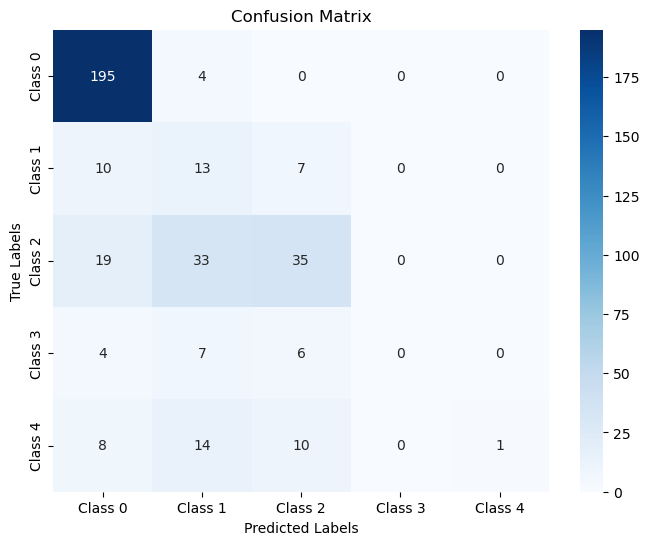

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import load_model

# Step 1: Load TFRecord Dataset

def parse_tfrecord(tfrecord_file, batch_size=32, img_size=(224, 224)):
    # Define the feature structure of the TFRecord (image, label)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }

    def _parse_function(proto):
        
    # Define TFRecord schema

    # Parse example
        parsed = tf.io.parse_single_example(proto, feature_description)
    # Decode and preprocess image
        image = tf.io.decode_jpeg(parsed['image'], channels=3)
        image = tf.image.resize(image, TARGET_SIZE) / 255.0  # Normalize
    
        label = tf.one_hot(parsed['label'], depth=NUM_CLASSES)
        return image, label
    
    # Create a dataset from the TFRecord file
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(_parse_function)  # Apply parsing function to each record
    dataset = dataset.batch(batch_size)  # Batch the dataset
    
    return dataset

# Step 3: Load the Test Dataset from TFRecord
tfrecord_file = '/media/mydisk/ICDCIT/TFRecords_preprocessed_APTOS/test.tfrecord'  # Replace with your TFRecord file path
test_dataset = parse_tfrecord(tfrecord_file)

# Step 4: Make Predictions and Calculate Confusion Matrix
y_true = []
y_pred = []

# Iterate through the dataset and make predictions
for images, labels in test_dataset:
    y_true.append(labels.numpy())  # True labels (one-hot encoded)
    preds = model.predict(images)  # Model predictions (probabilities)
    y_pred.append(np.argmax(preds, axis=1))  # Get class with the highest probability

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Step 5: Compute Confusion Matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Step 6: Plot Confusion Matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


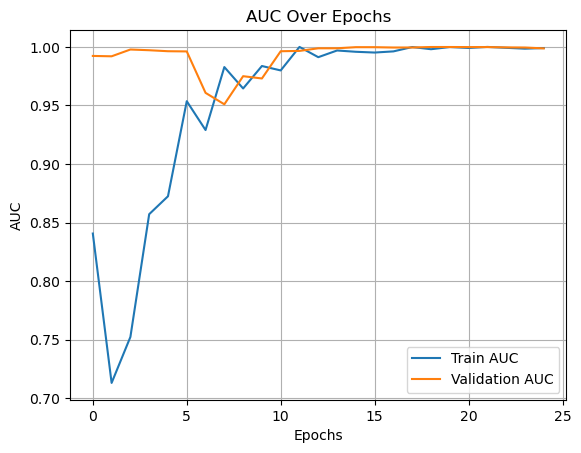

In [47]:
import matplotlib.pyplot as plt

# Assuming `history` is the result of `model.fit`
def plot_auc(history):
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_auc(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


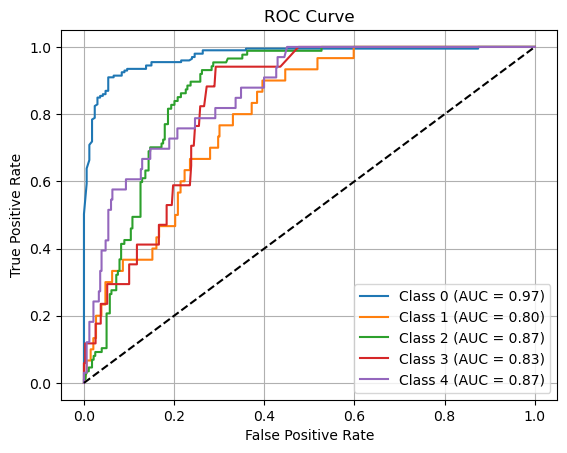

In [48]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Assuming val_dataset contains batched data
y_true = []
y_pred_prob = []

# Extract true labels and predicted probabilities
for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # True labels as integers
    y_pred_prob.extend(model.predict(images))  # Predicted probabilities

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC for each class
n_classes = y_pred_prob.shape[1]  # Number of classes
for i in range(n_classes):
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9851 - auc: 0.9992 - loss: 0.0662 - precision: 0.9849 - recall: 0.9740
Metrics Names: ['loss', 'compile_metrics']
loss: 0.07132339477539062
compile_metrics: 0.981249988079071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


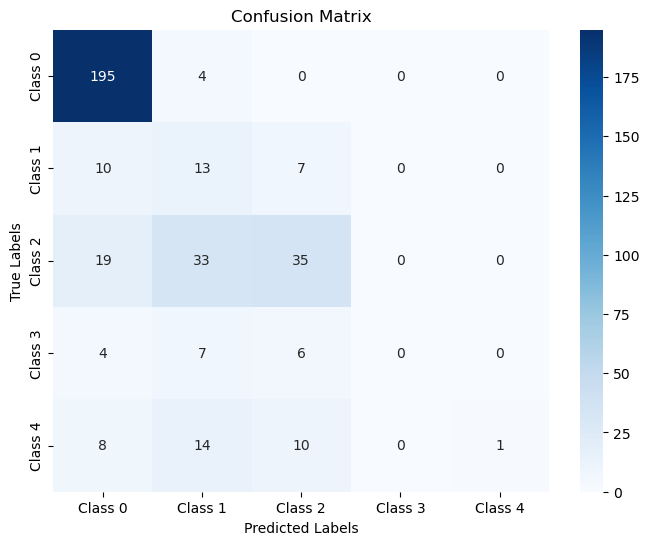

Accuracy: 0.6666666666666666


In [49]:
# Evaluate the model
results = model.evaluate(test_dataset, steps=test_samples // BATCH_SIZE)

# If you want more detailed information about the evaluation:
# Print the metric names
print("Metrics Names:", model.metrics_names)

# Print the evaluation results for each metric
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")

# To get more information such as confusion matrix, accuracy, and loss:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.append(labels.numpy())
    preds = model.predict(images)
    y_pred.append(np.argmax(preds, axis=1))

# Convert lists to numpy arrays
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_true, axis=1), y_pred)

# Plot confusion matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Optionally, calculate accuracy separately
accuracy = np.mean(np.argmax(y_true, axis=1) == y_pred)
print(f"Accuracy: {accuracy}")
